In [ ]:
print("Hello Quantum World of Rigetti")

# Forest

The Rigetti Forest Software Development Kit includes pyQuil, the Rigetti Quil Compiler (quilc), and the Quantum Virtual Machine (qvm).

The install instructions are concise and clear
* https://pyquil.readthedocs.io/en/stable/start.html#
* https://grove-docs.readthedocs.io/en/latest/installation.html#installation

### pyQuil + QVM

In 2 seperate terminals start

quilc -S

qvm -S

before starting the jupyter notebook session

In [1]:
from pyquil import Program, get_qc
from pyquil.gates import *

# construct a Bell State program
p = Program(H(0), CNOT(0, 1))

# run the program on a QVM
qc = get_qc('9q-square-qvm')
result = qc.run_and_measure(p, trials=10)
print(result[0])
print(result[1])

[1 1 1 1 1 0 0 0 0 1]
[1 1 1 1 1 0 0 0 0 1]


In [ ]:
# Method 2: instantiate a Program and add an operation to it.
p = Program()
p += X(0)

# run the program on a QVM
qc = get_qc('9q-square-qvm')
result = qc.run_and_measure(p, trials=3) # letting the QuantumComputer abstraction measure all qubits
print(result[0])
print(result[1])

# print pyQuil program to see the equivalent Quil representation
print(p)

Classical memory regions must be explicitly requested and named by a Quil program using the DECLARE directive. 

def declare(self, name, memory_type='BIT', memory_size=1, shared_region=None, offsets=None):
* name is any name you want to give this memory region.
* memory_type is one of 'REAL', 'BIT', 'OCTET', or 'INTEGER' (given as a string). Only BIT and OCTET always have a determined size, which is 1 bit and 8 bits respectively.
* memory_size is the number of elements of that type to reserve.
* shared_region and offsets allow you to alias memory regions. For example, you might want to name the third bit in your readout array as q3_ro. SHARING is currently disallowed for QPUs.

.declare cannot be chained, since it doesn’t return a modified Program object.

In [ ]:
# have to DECLARE a memory space to read measurement “readout results” and abbreviate as ro
p = Program()
roval = p.declare('ro', 'BIT', 2)
p += X(1)
p += MEASURE(0, roval[0])
p += MEASURE(1, roval[1])
print(p)

qc = get_qc('2q-qvm')  # any 'nq-qvm' can be made this way for any reasonable 'n'
executable = qc.compile(p)
result = qc.run(executable)
print(result)

The QPU can only handle MEASURE final programs. You can’t operate gates after measurements.

In [ ]:
p = Program()
roval = p.declare('ro', 'BIT', 1)
p += H(0)
p += MEASURE(0, roval[0])

p.wrap_in_numshots_loop(1000) # Method 2: specifying number of trials

qc = get_qc('1q-qvm') 
executable = qc.compile(p)
result = qc.run(executable)

ones = 0
for i in range(1000):
    if (result[i] == 1):
        ones += 1
print(ones) # expected around 50% of 1000

The Standard Gate Set of Quil and gates.py:
* Pauli gates I, X, Y, Z
* Hadamard gate: H
* Phase gates: PHASE(theta), S, T
* Controlled phase gates: CZ, CPHASE00(alpha), CPHASE01(alpha), CPHASE10(alpha), CPHASE(alpha)
* Cartesian rotation gates: RX(theta), RY(theta), RZ(theta)
* Controlled X gates: CNOT, CCNOT
* Swap gates: SWAP, CSWAP, ISWAP, PSWAP(alpha)

Gate applications in Quil can be preceded by a gate modifier. There are two supported modifiers: DAGGER and CONTROLLED

The parameterized gates take a real or complex floating point number as an argument.

Modern quantum algorithms are often parametric, following a hybrid model. In this hybrid model, the program ansatz (template of gates) is fixed, and iteratively updated with new parameters. These new parameters are often determined by an update given by a classical optimizer. Depending on the complexity of the algorithm, problem of interest, and capabilities of the classical optimizer, this loop may need to run many times. In order to efficiently operate within this hybrid model, parametric compilation can be used.

Parametric compilation allows one to compile the program ansatz just once. Making use of declared memory regions, we can **load values to the parametric gates at execution time, after compilation**. Taking the compiler out of the execution loop for programs like this offers a huge performance improvement compared to compiling the program each time a parameter update is required.

The first step is to build a parametric program, which functions like a template for all the precise programs that will run.

THe example below puts the qubit onto the equator of the Bloch Sphere and then rotates it around the Z axis for some variable angle theta before applying another X pulse and measuring. It is similar to an experiment which measures the qubit frequency.

In [ ]:
import numpy as np

qubit = 0

p = Program()
ro = p.declare("ro", "BIT", 1)
theta_ref = p.declare("theta", "REAL")

p += RX(np.pi / 2, qubit)
p += RZ(theta_ref, qubit)
p += RX(-np.pi / 2, qubit)

p += MEASURE(qubit, ro[0])

qc = get_qc("1q-qvm")
executable = qc.compile(p) # able to compile the program, even with theta still not specified

# Somewhere to store each list of results
parametric_measurements = []

for theta in np.linspace(0, 2 * np.pi, 200):
    # Get the results of the run with the value we want to execute with
    bitstrings = qc.run(executable, {'theta': [theta]})
    # Store our results
    parametric_measurements.append(bitstrings)

New gates can be easily added inline to Quil programs with a matrix representation of the gate. Custom parametric gates require a slightly different way.

In [ ]:
from pyquil.quil import DefGate
from pyquil.parameters import Parameter, quil_sin, quil_cos

# First we define the new gate from a matrix
sqrt_x = np.array([[ 0.5+0.5j,  0.5-0.5j],
                   [ 0.5-0.5j,  0.5+0.5j]])

# Get the Quil definition for the new gate
sqrt_x_definition = DefGate("SQRT-X", sqrt_x)
# Get the gate constructor
SQRT_X = sqrt_x_definition.get_constructor()

# Then we can use the new gate
p = Program()
p += sqrt_x_definition
p += SQRT_X(0)

# A multi-qubit defgate example
x_gate_matrix = np.array(([0.0, 1.0], [1.0, 0.0]))
sqrt_x = np.array([[ 0.5+0.5j,  0.5-0.5j],
                [ 0.5-0.5j,  0.5+0.5j]])
x_sqrt_x = np.kron(x_gate_matrix, sqrt_x)
x_sqrt_x_definition = DefGate("X-SQRT-X", x_sqrt_x)
X_SQRT_X = x_sqrt_x_definition.get_constructor()

# Then we can use the new gate
p += Program(x_sqrt_x_definition, X_SQRT_X(0, 1))

# Define the new gate from a matrix
theta = Parameter('theta')
crx = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, quil_cos(theta / 2), -1j * quil_sin(theta / 2)],
    [0, 0, -1j * quil_sin(theta / 2), quil_cos(theta / 2)]
])

gate_definition = DefGate('CRX', crx, [theta])
CRX = gate_definition.get_constructor()

# Create our program and use the new parametric gate
p += gate_definition
p += CRX(np.pi/2)(0, 1)

# Dynamic definition of custom parametric gate
theta_dyn= p.declare("theta", "REAL")
p += CRX(theta_dyn)(0, 1)

print(p)

p.pop() # If an instruction was appended to a program incorrectly (conditionally)
print(p)

Wavefunction Simulator allows directly inspecting the wavefunction of a quantum state prepared by the program. Because of the probabilistic nature of quantum information, the programs on the QPU can give a distribution of outputs. When running on the QPU or QVM, one can aggregate results (anywhere from tens of trials to 100k+!) that can be sampled to get back a distribution. With the Wavefunction Simulator, the distribution can be examined without having to collect samples from the program. This can save a lot of time for small programs. 

In [ ]:
from pyquil.api import WavefunctionSimulator

print(WavefunctionSimulator().wavefunction(p))

For more info, visit:
* https://pyquil.readthedocs.io/en/stable/basics.html#
* https://pyquil.readthedocs.io/en/stable/apidocs/program.html
* https://pyquil.readthedocs.io/en/stable/apidocs/gates.html

For compiler related settings:
* https://pyquil.readthedocs.io/en/stable/compiler.html#
* https://pyquil.readthedocs.io/en/stable/apidocs/compilers.html
* https://pyquil.readthedocs.io/en/stable/qvm-man.html
* https://pyquil.readthedocs.io/en/stable/quilc-man.html

For QPU related settings:
* https://pyquil.readthedocs.io/en/stable/qvm.html#the-quantum-processing-unit
* https://pyquil.readthedocs.io/en/stable/apidocs/quantum_computer.html
* https://pyquil.readthedocs.io/en/stable/apidocs/devices.html

For noise simulations:
* https://pyquil.readthedocs.io/en/stable/noise.html#
* https://pyquil.readthedocs.io/en/stable/apidocs/noise.html

Classical control flow is not yet supported in the QPU.
* https://pyquil.readthedocs.io/en/stable/advanced_usage.html#classical-control-flow

On QVM, the example below declare a register called flag_register to use as a boolean test for looping, initialized to 1, so while loop will execute. This is often called the loop preamble or loop initialization. The body of the loop is its own Program. This will be a program that applies an X gate followed by a H gate on a qubit. Using the while_do() method to add control flow.

The outer_loop program applied a Quil instruction directly to a classical register. There are several classical commands that can be used in this fashion:
* NOT which flips a classical bit
* AND which operates on two classical bits
* IOR which operates on two classical bits
* MOVE which moves the value of a classical bit at one classical address into another
* EXCHANGE which swaps the value of two classical bits

In [ ]:
# Initialize the Program and declare a 1 bit memory space for our boolean flag
outer_loop = Program()
flag_register = outer_loop.declare('flag_register', 'BIT')

# Set the initial flag value to 1
outer_loop += MOVE(flag_register, 1)

# Define the body of the loop with a new Program
inner_loop = Program()
inner_loop += Program(X(0), H(0))
inner_loop += MEASURE(0, flag_register)

# Run inner_loop in a loop until flag_register is 0
outer_loop.while_do(flag_register, inner_loop)

print(outer_loop)

Conditional branching in the form of the traditional if construct includes constructing programs for each branch of the if, and put it all together by using the if_then() method.

In [ ]:
# Declare our memory spaces
branching_prog = Program()
test_register = branching_prog.declare('test_register', 'BIT')
ro = branching_prog.declare('ro', 'BIT')

# Construct each branch of our if-statement. We can have empty branches
# simply by having empty programs.
then_branch = Program(X(0))
else_branch = Program()

# Construct our program so that the result in test_register is equally likely to be a 0 or 1
branching_prog += H(1)
branching_prog += MEASURE(1, test_register)

# Add the conditional branching
branching_prog.if_then(test_register, then_branch, else_branch)

# Measure qubit 0 into our readout register
branching_prog += MEASURE(0, ro)

print(branching_prog)

qc = get_qc("2q-qvm")
branching_prog.wrap_in_numshots_loop(10)
qc.run(branching_prog)

The Probabilistic Halting Problem: A fun example is to create a program that has an exponentially increasing chance of halting, but that may run forever!

In [ ]:
p = Program()
ro = p.declare('ro', 'BIT', 1)
inside_loop = Program(H(0)).measure(0, ro[0])
p.inst(X(0)).while_do(ro[0], inside_loop)

qc = get_qc('9q-square-qvm')
print (qc.run(qc.compile(p)))

Quantum Algorithms developed on Forest
* https://www.rigetti.com/community
* https://github.com/msohaibalam/Link_to_Quantum_game
* https://github.com/qosf/os_quantum_software

### Grove

A collection of quantum algorithms built using the Rigetti Forest platform.
* Variational-Quantum-Eigensolver (VQE)
* Quantum Approximate Optimization Algorithm (QAOA)
* Quantum Fourier Transform (QFT)
* Phase Estimation Algorithm
* Histogram based Tomography
* Grover’s Search Algorithm and Amplitude Amplification
* Bernstein-Vazirani Algorithm
* Simon’s Algorithm
* Deutsch-Jozsa Algorithm
* Arbitrary State Generation

Links:
* https://grove-docs.readthedocs.io/en/latest/
* https://github.com/rigetti/grove

Variational Quantum Eigensolver for Pauli-Z Hamiltonian (ground state eigenvalue is -1)

In [31]:
from pyquil.quil import Program
import pyquil.api as api
from pyquil.gates import *
qvm = api.QVMConnection()

def ansatz (params):
    return Program(RY(params[0],0))

from pyquil.paulis import sZ, sX, sI

hamiltonian = sZ(0) # Our Hamiltonian is just \sigma_z on the zeroth qubit
#hamiltonian = sX(0) + sZ(0) # -1.4
#hamiltonian = 0.2*sX(0) + 0.9*sZ(0) # -0.9

from grove.pyvqe.vqe import VQE
from scipy.optimize import minimize
import numpy as np

vqe_inst = VQE(minimizer=minimize, minimizer_kwargs={'method':'nelder-mead'})
initial_angle = [ 0.0 ]
result = vqe_inst.vqe_run(ansatz, hamiltonian, initial_angle, samples=None, qvm=qvm)
print(result)
print(hamiltonian)

                     models will be ineffective
{'x': array([3.1415625]), 'fun': -0.9999999995453805}
(1+0j)*Z0


Variational Quantum Eigensolver for sum of tensor products of Pauli operators weighted by constant coefficients

$min(eig(0.2*kron(x,kron(z,x)) + 0.9*kron(x,kron(eye(2),x)) + 0.3*kron(z,kron(z,z)))) = -1.4$

In [14]:
from pyquil.quil import Program
import pyquil.api as api
from pyquil.gates import *
qvm = api.QVMConnection()

n_qubits, depth = 1, 1

'''
def ansatz (params):
    p = Program()
    for i in range(depth):
        p += CNOT(2, 0)
        for j in range(n_qubits):
            p += Program(RY(params[j], j))
    return p
'''
def ansatz (params):
    return Program(RY(params[0],0))

from pyquil.paulis import sZ, sX, sI

#hamiltonian = 0.2*sX(2)*sZ(1)*sX(0) + 0.9*sX(2)*sI(1)*sX(0) + 0.3*sZ(2)*sZ(1)*sZ(0)
#hamiltonian = sZ(0) # -1.0, [3.13927926]
#hamiltonian = sX(0) # -1.0, [4.70891889]
#hamiltonian = sX(0) + sZ(0) # -1.4, [3.9280429]
#hamiltonian = 0.5*sX(0) + 0.5*sZ(0) # -0.7071, [3.9280429]
#hamiltonian = 0.2*sX(0) + 0.9*sZ(0) # -0.9219, [3.36013308]
hamiltonian = 0.3*sX(0) + 0.7*sZ(0) # -0.9219, [3.36013308]
#hamiltonian = sX(1)*sX(0) # -1.0
#hamiltonian = sZ(1)*sZ(0) # -1.0
#hamiltonian = 0.3*sZ(2)*sZ(1)*sZ(0) # -0.3
#hamiltonian = 0.9*sX(2)*sI(1)*sX(0) # -0.9
#hamiltonian = 0.2*sX(2)*sZ(1)*sX(0) # -0.2

from grove.pyvqe.vqe import VQE
from scipy.optimize import minimize
import numpy as np

vqe_inst = VQE(minimizer=minimize, minimizer_kwargs={'method':'nelder-mead', 'options':{'xatol':1.0e-2,'disp':True}})
np.random.seed(999)
initial_params = np.random.uniform(0.0, 2*np.pi, size=n_qubits)
result = vqe_inst.vqe_run(ansatz, hamiltonian, initial_params, samples=None, qvm=qvm)
print(result)
print(hamiltonian)


                     models will be ineffective
Optimization terminated successfully.
         Current function value: -0.761574
         Iterations: 10
         Function evaluations: 20
{'x': array([3.54943635]), 'fun': -0.7615739924772624}
(0.3+0j)*X0 + (0.7+0j)*Z0


Quantum Approximate Optimization Algorithm (QAOA) for Max-Cut on a undirected unweighted square-ring

                     models will be ineffective
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -2.049925600216813
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9258329661561333
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9055510767742194
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9162753977320983
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9523211651307175
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -1.9499823964379095
	Parameters: [2.58486558 0.26878684 1.57068456 4.49965144] 
	E => -2.0101089272813772
	Parameters: [2.55773524 0.28664526 1.62036329 4.06191069] 
	E => -2.239872137660691
	Parameters: [2.55773524 0.28664526 1.62036329 4.06191069] 
	E => -2.088451236810917
	Parameters: [2.51623165 0.27857523 1.77821333 3.73748437] 
	E => -2.6345231341476465
	Parameters: [2.51623165 0.27857523 1.77821333 3.73748437] 
	E => -2.4430524348604856
	Paramete

	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9994084998097734
	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9990086315217765
	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9978018402418547
	Parameters: [1.96062489 0.78057272 1.57783502 3.9227825 ] 
	E => -3.9992228580557323
	Parameters: [1.96750773 0.78235638 1.56240669 3.94097575] 
	E => -3.999411486167628
	Parameters: [1.96637265 0.78410088 1.55210464 3.93517475] 
	E => -3.9995611319901188
	Parameters: [1.96637265 0.78410088 1.55210464 3.93517475] 
	E => -3.999522529950024
	Parameters: [1.96564351 0.78442817 1.57818112 3.91829849] 
	E => -3.9989414034310946
	Parameters: [1.96401775 0.78148373 1.57104348 3.92639008] 
	E => -3.999904767407205
	Parameters: [1.96401775 0.78148373 1.57104348 3.92639008] 
	E => -3.999811022305246
	Parameters: [1.96140985 0.78744607 1.56855377 3.93122177] 
	E => -3.999471774586656
	Parameters: [1.96140985 0.78744607 1.56855377 3.93122177] 

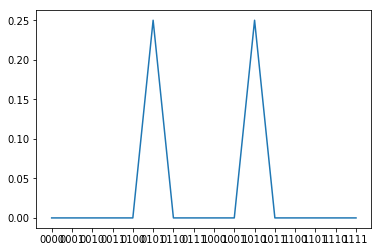

In [14]:
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
import pyquil.api as api
qvm_connection = api.QVMConnection()

square_ring = [(0,1),(1,2),(2,3),(3,0)]

steps = 2
inst = maxcut_qaoa(graph=square_ring, steps=steps)
betas, gammas = inst.get_angles()

t = np.hstack((betas, gammas))
param_prog = inst.get_parameterized_program()
prog = param_prog(t)
wf = qvm_connection.wavefunction(prog)
wf = wf.amplitudes

for state_index in range(inst.nstates):
    print(inst.states[state_index], np.conj(wf[state_index])*wf[state_index])
    
import matplotlib.pyplot as plt
import cmath 
plt.plot(inst.states, np.conj(wf).real*wf.real)

                     models will be ineffective
	Parameters: [1.25645056 2.9900598  3.01455935 1.38033789 2.55032145 4.8135511
 3.78535813 0.0950545  2.11352323 0.4555207 ] 
	E => -4.516224896374062
	Parameters: [1.25645056 2.9900598  3.01455935 1.38033789 2.55032145 4.8135511
 3.78535813 0.0950545  2.11352323 0.4555207 ] 
	E => -4.612562222005987
	Parameters: [1.25645056 2.9900598  3.01455935 1.38033789 2.55032145 4.8135511
 3.78535813 0.0950545  2.11352323 0.4555207 ] 
	E => -4.524137147175092
	Parameters: [1.25645056 2.9900598  3.01455935 1.38033789 2.55032145 4.8135511
 3.78535813 0.0950545  2.11352323 0.4555207 ] 
	E => -4.5938428434251275
	Parameters: [1.25645056 2.9900598  3.01455935 1.38033789 2.55032145 4.8135511
 3.78535813 0.0950545  2.11352323 0.4555207 ] 
	E => -4.6815760231333226
	Parameters: [1.25645056 2.9900598  3.01455935 1.38033789 2.55032145 4.8135511
 3.78535813 0.0950545  2.11352323 0.4555207 ] 
	E => -4.774519739186567
	Parameters: [1.25645056 2.9900598  3.014559

	Parameters: [0.98091573 3.06055587 2.84741201 1.61867836 2.56319412 4.77681144
 4.01786612 0.11855074 2.07697645 0.37761979] 
	E => -5.183871187650206
	Parameters: [0.98091573 3.06055587 2.84741201 1.61867836 2.56319412 4.77681144
 4.01786612 0.11855074 2.07697645 0.37761979] 
	E => -5.217149099916052
	Parameters: [1.00353885 2.90056068 2.93659092 1.61519311 2.55355893 4.76416173
 3.98550604 0.11597181 2.08014171 0.39634851] 
	E => -5.229228828536348
	Parameters: [1.01426891 2.97783824 2.83556409 1.57300979 2.53545492 4.86459342
 3.929802   0.12819944 2.08701038 0.3741701 ] 
	E => -5.309547047093635
	Parameters: [1.01426891 2.97783824 2.83556409 1.57300979 2.53545492 4.86459342
 3.929802   0.12819944 2.08701038 0.3741701 ] 
	E => -5.212916300160766
	Parameters: [1.01426891 2.97783824 2.83556409 1.57300979 2.53545492 4.86459342
 3.929802   0.12819944 2.08701038 0.3741701 ] 
	E => -5.285084881368642
	Parameters: [1.01426891 2.97783824 2.83556409 1.57300979 2.53545492 4.86459342
 3.92980

	Parameters: [0.98727625 3.00139159 2.80889285 1.61438924 2.50062016 4.77698918
 4.04198616 0.13184753 2.0301677  0.34393289] 
	E => -5.367212969369297
	Parameters: [0.98727625 3.00139159 2.80889285 1.61438924 2.50062016 4.77698918
 4.04198616 0.13184753 2.0301677  0.34393289] 
	E => -5.3612090744504615
	Parameters: [0.98727625 3.00139159 2.80889285 1.61438924 2.50062016 4.77698918
 4.04198616 0.13184753 2.0301677  0.34393289] 
	E => -5.366591519527875
	Parameters: [0.97392627 3.02605042 2.78494608 1.60514359 2.52294232 4.7612829
 4.0304953  0.13317289 2.03446678 0.34202233] 
	E => -5.376724999810397
	Parameters: [0.97392627 3.02605042 2.78494608 1.60514359 2.52294232 4.7612829
 4.0304953  0.13317289 2.03446678 0.34202233] 
	E => -5.362563103499308
	Parameters: [0.97392627 3.02605042 2.78494608 1.60514359 2.52294232 4.7612829
 4.0304953  0.13317289 2.03446678 0.34202233] 
	E => -5.370714838394725
	Parameters: [0.97392627 3.02605042 2.78494608 1.60514359 2.52294232 4.7612829
 4.0304953 

	Parameters: [0.9534734  3.07418109 2.71897602 1.57376847 2.49639866 4.6953176
 4.06461092 0.14592942 1.9633188  0.30934192] 
	E => -5.411501143337193
	Parameters: [0.9534734  3.07418109 2.71897602 1.57376847 2.49639866 4.6953176
 4.06461092 0.14592942 1.9633188  0.30934192] 
	E => -5.410577578995181
	Parameters: [0.9534734  3.07418109 2.71897602 1.57376847 2.49639866 4.6953176
 4.06461092 0.14592942 1.9633188  0.30934192] 
	E => -5.410746927133729
	Parameters: [0.95748916 3.09528561 2.70512156 1.55843378 2.50942582 4.7047934
 4.04903999 0.14492631 1.97986107 0.31343118] 
	E => -5.411890119744445
	Parameters: [0.95748916 3.09528561 2.70512156 1.55843378 2.50942582 4.7047934
 4.04903999 0.14492631 1.97986107 0.31343118] 
	E => -5.412169480588254
	Parameters: [0.95748916 3.09528561 2.70512156 1.55843378 2.50942582 4.7047934
 4.04903999 0.14492631 1.97986107 0.31343118] 
	E => -5.412883129934005
	Parameters: [0.95748916 3.09528561 2.70512156 1.55843378 2.50942582 4.7047934
 4.04903999 0.1

	Parameters: [0.96045715 3.14636226 2.65108424 1.54568513 2.52068522 4.71532353
 4.03788213 0.14913039 2.01073881 0.31453912] 
	E => -5.416563008877205
	Parameters: [0.95618467 3.15964311 2.63547737 1.54640405 2.52220933 4.71689986
 4.04174288 0.1496288  2.0114117  0.31193745] 
	E => -5.417376056280432
	Parameters: [0.96793484 3.16085686 2.63103059 1.54441666 2.52585825 4.72940424
 4.02287482 0.15054473 2.02282144 0.31451945] 
	E => -5.4182094516828085
	Parameters: [0.96793484 3.16085686 2.63103059 1.54441666 2.52585825 4.72940424
 4.02287482 0.15054473 2.02282144 0.31451945] 
	E => -5.417615427734495
	Parameters: [0.9690486  3.19098447 2.59695512 1.54145579 2.52136351 4.74449084
 4.01171625 0.1536178  2.03984093 0.31233013] 
	E => -5.419187353657793
	Parameters: [0.9690486  3.19098447 2.59695512 1.54145579 2.52136351 4.74449084
 4.01171625 0.1536178  2.03984093 0.31233013] 
	E => -5.418110265297452
	Parameters: [0.9690486  3.19098447 2.59695512 1.54145579 2.52136351 4.74449084
 4.0117

	Parameters: [0.98289053 3.51332998 2.25808406 1.54953442 2.49838631 4.70582053
 4.08150448 0.17190473 2.13553679 0.27413794] 
	E => -5.440053914096748
	Parameters: [0.98289053 3.51332998 2.25808406 1.54953442 2.49838631 4.70582053
 4.08150448 0.17190473 2.13553679 0.27413794] 
	E => -5.440049299096901
	Parameters: [0.98289053 3.51332998 2.25808406 1.54953442 2.49838631 4.70582053
 4.08150448 0.17190473 2.13553679 0.27413794] 
	E => -5.437498177068895
	Parameters: [0.99216661 3.5407969  2.21224029 1.53643323 2.49866136 4.71178589
 4.08714209 0.17456808 2.14749844 0.26911283] 
	E => -5.444481388213765
	Parameters: [0.99216661 3.5407969  2.21224029 1.53643323 2.49866136 4.71178589
 4.08714209 0.17456808 2.14749844 0.26911283] 
	E => -5.443701735888454
	Parameters: [0.99216661 3.5407969  2.21224029 1.53643323 2.49866136 4.71178589
 4.08714209 0.17456808 2.14749844 0.26911283] 
	E => -5.443340895247247
	Parameters: [0.99216661 3.5407969  2.21224029 1.53643323 2.49866136 4.71178589
 4.08714

	Parameters: [0.97100987 3.6005656  2.14274032 1.52787232 2.50398872 4.69520707
 4.12445683 0.17869406 2.13708178 0.25256594] 
	E => -5.451910600082128
	Parameters: [0.97100987 3.6005656  2.14274032 1.52787232 2.50398872 4.69520707
 4.12445683 0.17869406 2.13708178 0.25256594] 
	E => -5.451585357092872
	Parameters: [0.97100987 3.6005656  2.14274032 1.52787232 2.50398872 4.69520707
 4.12445683 0.17869406 2.13708178 0.25256594] 
	E => -5.451084011442264
	Parameters: [0.97100987 3.6005656  2.14274032 1.52787232 2.50398872 4.69520707
 4.12445683 0.17869406 2.13708178 0.25256594] 
	E => -5.451355202728935
	Parameters: [0.97175426 3.58097238 2.16230966 1.51737    2.51158488 4.6954496
 4.12646716 0.17813273 2.12502369 0.25305256] 
	E => -5.453377510800045
	Parameters: [0.97175426 3.58097238 2.16230966 1.51737    2.51158488 4.6954496
 4.12646716 0.17813273 2.12502369 0.25305256] 
	E => -5.451780940650335
	Parameters: [0.97175426 3.58097238 2.16230966 1.51737    2.51158488 4.6954496
 4.12646716

	Parameters: [0.95168292 3.69032795 2.04302369 1.46044171 2.58373077 4.67125678
 4.22796108 0.17756255 2.08829447 0.21693664] 
	E => -5.470155628051854
	Parameters: [0.95168292 3.69032795 2.04302369 1.46044171 2.58373077 4.67125678
 4.22796108 0.17756255 2.08829447 0.21693664] 
	E => -5.467850213604325
	Parameters: [0.95168292 3.69032795 2.04302369 1.46044171 2.58373077 4.67125678
 4.22796108 0.17756255 2.08829447 0.21693664] 
	E => -5.468407957542421
	Parameters: [0.94763663 3.69939449 2.02953741 1.44422972 2.6042321  4.68664217
 4.25327708 0.17212508 2.088974   0.21506854] 
	E => -5.472924604168251
	Parameters: [0.94763663 3.69939449 2.02953741 1.44422972 2.6042321  4.68664217
 4.25327708 0.17212508 2.088974   0.21506854] 
	E => -5.470755799811458
	Parameters: [0.94763663 3.69939449 2.02953741 1.44422972 2.6042321  4.68664217
 4.25327708 0.17212508 2.088974   0.21506854] 
	E => -5.472420176606361
	Parameters: [0.94763663 3.69939449 2.02953741 1.44422972 2.6042321  4.68664217
 4.25327

	Parameters: [0.95654876 3.7477463  1.99535339 1.35451955 2.7198291  4.68643295
 4.28700516 0.16653615 2.06604374 0.20126294] 
	E => -5.4883552236256845
	Parameters: [0.95654876 3.7477463  1.99535339 1.35451955 2.7198291  4.68643295
 4.28700516 0.16653615 2.06604374 0.20126294] 
	E => -5.4881108626249855
	Parameters: [0.95654876 3.7477463  1.99535339 1.35451955 2.7198291  4.68643295
 4.28700516 0.16653615 2.06604374 0.20126294] 
	E => -5.488473618188711
	Parameters: [0.95654876 3.7477463  1.99535339 1.35451955 2.7198291  4.68643295
 4.28700516 0.16653615 2.06604374 0.20126294] 
	E => -5.487495877338249
	Parameters: [0.95654876 3.7477463  1.99535339 1.35451955 2.7198291  4.68643295
 4.28700516 0.16653615 2.06604374 0.20126294] 
	E => -5.488604000172473
	Parameters: [0.95485409 3.78006624 1.96155109 1.34145571 2.73535746 4.68007786
 4.30819743 0.16716598 2.06189414 0.19265287] 
	E => -5.4879708199108315
	Parameters: [0.95485409 3.78006624 1.96155109 1.34145571 2.73535746 4.68007786
 4.30

	Parameters: [0.96422843 3.77647848 1.96847112 1.32540379 2.74946194 4.69216184
 4.29321121 0.1666308  2.0756474  0.1984604 ] 
	E => -5.490792777448273
	Parameters: [0.96422843 3.77647848 1.96847112 1.32540379 2.74946194 4.69216184
 4.29321121 0.1666308  2.0756474  0.1984604 ] 
	E => -5.490736949925086
	Parameters: [0.96422843 3.77647848 1.96847112 1.32540379 2.74946194 4.69216184
 4.29321121 0.1666308  2.0756474  0.1984604 ] 
	E => -5.490790681157255
	Parameters: [0.96667258 3.78147198 1.96495475 1.32214335 2.75254885 4.69133526
 4.29073727 0.16729652 2.07727491 0.19814579] 
	E => -5.490700640098859
	Parameters: [0.96457878 3.77620348 1.96637752 1.32599436 2.7502911  4.69040391
 4.29311844 0.16719357 2.07379929 0.19729056] 
	E => -5.490818543703636


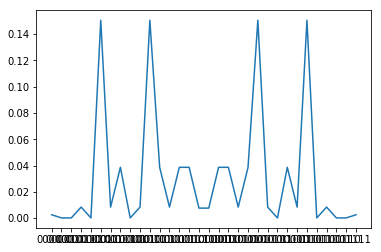

In [26]:
import matplotlib.pyplot as plt
import cmath 
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
import pyquil.api as api
qvm_connection = api.QVMConnection()

#wiki = [(0,1),(0,2),(0,3),(0,4),[0,5],[5,4]]
wiki = [(0,1),(1,2),(2,3),(3,0),[0,4],[1,4],[2,4],[3,4]]

steps = 6
inst = maxcut_qaoa(graph=wiki, steps=steps)
betas, gammas = inst.get_angles()

t = np.hstack((betas, gammas))
param_prog = inst.get_parameterized_program()
prog = param_prog(t)
wf = qvm_connection.wavefunction(prog)
wf = wf.amplitudes
plt.plot(inst.states, abs(np.conj(wf)*wf))



#for state_index in range(inst.nstates):
#    print(inst.states[state_index], abs(np.conj(wf[state_index])*wf[state_index]))
    



The set with the minimum number of 0 or 1, is the vertex cover (among the solution strings of Max-Cut)

In [28]:
from pyquil.paulis import PauliTerm, PauliSum, exponential_map
from pyquil.gates import STANDARD_GATES

cost_operators = []
cost_operators.append(PauliTerm("Z", 0, 0.5)*PauliTerm("Z", 1) + PauliTerm("I", 0, -0.5))
cost_operators.append(PauliTerm("Z", 1, 0.5)*PauliTerm("Z", 2) + PauliTerm("I", 1, -0.5))

print("cost_operators: ",cost_operators)
for cost_pauli_sum in cost_operators:
    print("\tcost_pauli_sum: ",cost_pauli_sum)
    print("\tcost_pauli_sum.terms: ",cost_pauli_sum.terms)
    for term in cost_pauli_sum.terms:
        print("\t\tterm: ",term)
        a = exponential_map(term)
        print("\t\texponential_map(term): ",a)
        print("\t\tdeparameterised: ",a(1.14))
        for qindex, op in term:
            print("\t\t\tqindex,op,term.coefficient: ",qindex,op,term.coefficient)
            print("\t\t\t: ",STANDARD_GATES[op](qindex))
        
driver_operators = []
driver_operators.append(PauliSum([PauliTerm("X", 0, -1.0)]))
driver_operators.append(PauliSum([PauliTerm("X", 1, -1.0)]))
driver_operators.append(PauliSum([PauliTerm("X", 2, -1.0)]))                                               

print("driver_operators: ",driver_operators)
for driver_pauli_sum in driver_operators:
    print("\tdriver_pauli_sum: ",driver_pauli_sum)
    print("\tdriver_pauli_sum.terms: ",driver_pauli_sum.terms)
    for term in driver_pauli_sum.terms:
        print("\t\tterm: ",term)
        a = exponential_map(term)
        print("\t\texponential_map(term): ",a)
        print("\t\tdeparameterised: ",a(1.14))
        for qindex, op in term:
            print("\t\t\tqindex,op,term.coefficient: ",qindex,op,term.coefficient)
            print("\t\t\t: ",STANDARD_GATES[op](qindex))

cost_operators:  [<pyquil.paulis.PauliSum object at 0x7fa72546dfd0>, <pyquil.paulis.PauliSum object at 0x7fa7254850b8>]
	cost_pauli_sum:  (0.5+0j)*Z0*Z1 + (-0.5+0j)*I
	cost_pauli_sum.terms:  [<pyquil.paulis.PauliTerm object at 0x7fa725486fd0>, <pyquil.paulis.PauliTerm object at 0x7fa7254dd128>]
		term:  (0.5+0j)*Z0*Z1
		exponential_map(term):  <function exponential_map.<locals>.exp_wrap at 0x7fa7254d9b70>
		deparameterised:  CNOT 0 1
RZ(1.14) 1
CNOT 0 1

			qindex,op,term.coefficient:  0 Z 0.5
			:  Z 0
			qindex,op,term.coefficient:  1 Z 0.5
			:  Z 1
		term:  (-0.5+0j)*I
		exponential_map(term):  <function exponential_map.<locals>.exp_wrap at 0x7fa72546a8c8>
		deparameterised:  X 0
PHASE(0.57) 0
X 0
PHASE(0.57) 0

	cost_pauli_sum:  (0.5+0j)*Z1*Z2 + (-0.5+0j)*I
	cost_pauli_sum.terms:  [<pyquil.paulis.PauliTerm object at 0x7fa72546df98>, <pyquil.paulis.PauliTerm object at 0x7fa72546d0b8>]
		term:  (0.5+0j)*Z1*Z2
		exponential_map(term):  <function exponential_map.<locals>.exp_wrap at 0

In [17]:
##############################################################################
# Copyright 2016-2017 Rigetti Computing
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.
##############################################################################

from collections import Counter
from scipy import optimize
import numpy as np
from grove.pyvqe.vqe import VQE
import pyquil.quil as pq
from pyquil.gates import H
from pyquil.paulis import exponential_map, PauliSum
from functools import reduce


class QAOA(object):
    def __init__(self, qvm, qubits, steps=1, init_betas=None,
                 init_gammas=None, cost_ham=None,
                 ref_ham=None, driver_ref=None,
                 minimizer=None, minimizer_args=None,
                 minimizer_kwargs=None, rand_seed=None,
                 vqe_options=None, store_basis=False):
        """
        QAOA object.

        Contains all information for running the QAOA algorthm to find the
        ground state of the list of cost clauses.

        N.B. This only works if all the terms in the cost Hamiltonian commute with each other.

        :param qvm: (Connection) The qvm connection to use for the algorithm.
        :param qubits: (list of ints) The number of qubits to use for the algorithm.
        :param steps: (int) The number of mixing and cost function steps to use.
                      Default=1.
        :param init_betas: (list) Initial values for the beta parameters on the
                           mixing terms. Default=None.
        :param init_gammas: (list) Initial values for the gamma parameters on the
                            cost function. Default=None.
        :param cost_ham: list of clauses in the cost function. Must be
                    PauliSum objects
        :param ref_ham: list of clauses in the mixer function. Must be
                    PauliSum objects
        :param driver_ref: (pyQuil.quil.Program()) object to define state prep
                           for the starting state of the QAOA algorithm.
                           Defaults to tensor product of \|+> states.
        :param rand_seed: integer random seed for initial betas and gammas
                          guess.
        :param minimizer: (Optional) Minimization function to pass to the
                          Variational-Quantum-Eigensolver method
        :param minimizer_kwargs: (Optional) (dict) of optional arguments to pass to
                                 the minimizer.  Default={}.
        :param minimizer_args: (Optional) (list) of additional arguments to pass to the
                               minimizer. Default=[].
        :param minimizer_args: (Optional) (list) of additional arguments to pass to the
                               minimizer. Default=[].
        :param vqe_options: (optinal) arguents for VQE run.
        :param store_basis: (optional) boolean flag for storing basis states.
                            Default=False.
        """

        # Seed the random number generator, if a seed is provided.
        if rand_seed is not None:
            np.random.seed(rand_seed)

        # Set attributes values, considering their defaults
        self.qvm = qvm
        self.steps = steps
        self.qubits = qubits
        self.nstates = 2 ** len(qubits)

        self.cost_ham = cost_ham or []
        self.ref_ham = ref_ham or []

        self.minimizer = minimizer or optimize.minimize
        self.minimizer_args = minimizer_args or []
        self.minimizer_kwargs = minimizer_kwargs or {
            'method': 'Nelder-Mead',
            'options': {
                'disp': True,
                'ftol': 1.0e-2,
                'xtol': 1.0e-2
            }
        }

        self.betas = init_betas or np.random.uniform(0, np.pi, self.steps)[::-1]
        self.gammas = init_gammas or np.random.uniform(0, 2*np.pi, self.steps)
        self.vqe_options = vqe_options or {}

        self.ref_state_prep = (
            driver_ref or
            pq.Program([H(i) for i in self.qubits])
        )

        if store_basis:
            self.states = [
                np.binary_repr(i, width=len(self.qubits))
                for i in range(self.nstates)
            ]

        # Check argument types
        if not isinstance(self.cost_ham, (list, tuple)):
            raise TypeError("cost_ham must be a list of PauliSum objects.")
        if not all([isinstance(x, PauliSum) for x in self.cost_ham]):
            raise TypeError("cost_ham must be a list of PauliSum objects")

        if not isinstance(self.ref_ham, (list, tuple)):
            raise TypeError("ref_ham must be a list of PauliSum objects")
        if not all([isinstance(x, PauliSum) for x in self.ref_ham]):
            raise TypeError("ref_ham must be a list of PauliSum objects")

        if not isinstance(self.ref_state_prep, pq.Program):
            raise TypeError("Please provide a pyQuil Program object "
                            "to generate initial state.")

    def get_parameterized_program(self):
        """
        Return a function that accepts parameters and returns a new Quil
        program.

        :returns: a function
        """
        cost_para_programs = []
        driver_para_programs = []

        for idx in range(self.steps):
            cost_list = []
            driver_list = []
            for cost_pauli_sum in self.cost_ham:
                for term in cost_pauli_sum.terms:
                    cost_list.append(exponential_map(term))

            for driver_pauli_sum in self.ref_ham:
                for term in driver_pauli_sum.terms:
                    driver_list.append(exponential_map(term))

            cost_para_programs.append(cost_list)
            driver_para_programs.append(driver_list)

        def psi_ref(params):
            """
            Construct a Quil program for the vector (beta, gamma).

            :param params: array of 2 . p angles, betas first, then gammas
            :return: a pyquil program object
            """
            if len(params) != 2*self.steps:
                raise ValueError("params doesn't match the number of parameters set by `steps`")
            betas = params[:self.steps]
            gammas = params[self.steps:]

            prog = pq.Program()
            prog += self.ref_state_prep
            for idx in range(self.steps):
                for fprog in cost_para_programs[idx]:
                    prog += fprog(gammas[idx])

                for fprog in driver_para_programs[idx]:
                    prog += fprog(betas[idx])

            return prog

        return psi_ref

    def get_angles(self):
        """
        Finds optimal angles with the quantum variational eigensolver method.

        Stored VQE result

        :returns: ([list], [list]) A tuple of the beta angles and the gamma
                  angles for the optimal solution.
        """
        stacked_params = np.hstack((self.betas, self.gammas))
        vqe = VQE(self.minimizer, minimizer_args=self.minimizer_args,
                  minimizer_kwargs=self.minimizer_kwargs)
        cost_ham = reduce(lambda x, y: x + y, self.cost_ham)
        # maximizing the cost function!
        param_prog = self.get_parameterized_program()
        result = vqe.vqe_run(param_prog, cost_ham, stacked_params, qvm=self.qvm,
                             **self.vqe_options)
        self.result = result
        betas = result.x[:self.steps]
        gammas = result.x[self.steps:]
        return betas, gammas

    def probabilities(self, angles):
        """
        Computes the probability of each state given a particular set of angles.

        :param angles: [list] A concatenated list of angles [betas]+[gammas]
        :return: [list] The probabilities of each outcome given those angles.
        """
        if isinstance(angles, list):
            angles = np.array(angles)

        assert angles.shape[0] == 2 * self.steps, "angles must be 2 * steps"

        param_prog = self.get_parameterized_program()
        prog = param_prog(angles)
        print(prog)
        print("hhh")
        wf = self.qvm.wavefunction(prog)
        wf = wf.amplitudes.reshape((-1, 1))
        probs = np.zeros_like(wf)
        for xx in range(2 ** len(self.qubits)):
            probs[xx] = np.conj(wf[xx]) * wf[xx]
        return probs

    def get_string(self, betas, gammas, samples=100):
        """
        Compute the most probable string.

        The method assumes you have passed init_betas and init_gammas with your
        pre-computed angles or you have run the VQE loop to determine the
        angles.  If you have not done this you will be returning the output for
        a random set of angles.

        :param betas: List of beta angles
        :param gammas: List of gamma angles
        :param samples: (int, Optional) number of samples to get back from the
                        QVM.
        :returns: tuple representing the bitstring, Counter object from
                  collections holding all output bitstrings and their frequency.
        """
        if samples <= 0 and not isinstance(samples, int):
            raise ValueError("samples variable must be positive integer")
        param_prog = self.get_parameterized_program()
        stacked_params = np.hstack((betas, gammas))
        sampling_prog = param_prog(stacked_params)

        bitstring_samples = self.qvm.run_and_measure(sampling_prog,
                                                     self.qubits,
                                                     trials=samples)
        bitstring_tuples = list(map(tuple, bitstring_samples))
        freq = Counter(bitstring_tuples)
        most_frequent_bit_string = max(freq, key=lambda x: freq[x])
        return most_frequent_bit_string, freq


In [19]:
##############################################################################
# Copyright 2016-2017 Rigetti Computing
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.
##############################################################################

"""
Finding a maximum cut by QAOA.
"""
import numpy as np
import pyquil.api as api
from pyquil.paulis import PauliTerm, PauliSum
import networkx as nx
from scipy.optimize import minimize
CXN = api.QVMConnection()


def print_fun(x):
    print(x)


def maxcut_qaoa(graph, steps=1, rand_seed=None, connection=None, samples=None,
                initial_beta=None, initial_gamma=None, minimizer_kwargs=None,
                vqe_option=None):
    """
    Max cut set up method

    :param graph: Graph definition. Either networkx or list of tuples
    :param steps: (Optional. Default=1) Trotterization order for the QAOA algorithm.
    :param rand_seed: (Optional. Default=None) random seed when beta and gamma angles
        are not provided.
    :param connection: (Optional) connection to the QVM. Default is None.
    :param samples: (Optional. Default=None) VQE option. Number of samples
        (circuit preparation and measurement) to use in operator averaging.
    :param initial_beta: (Optional. Default=None) Initial guess for beta parameters.
    :param initial_gamma: (Optional. Default=None) Initial guess for gamma parameters.
    :param minimizer_kwargs: (Optional. Default=None). Minimizer optional arguments.  If None set to
        ``{'method': 'Nelder-Mead', 'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2, 'disp': False}``
    :param vqe_option: (Optional. Default=None). VQE optional arguments.  If None set to
        ``vqe_option = {'disp': print_fun, 'return_all': True, 'samples': samples}``

    """
    if not isinstance(graph, nx.Graph) and isinstance(graph, list):
        maxcut_graph = nx.Graph()
        for edge in graph:
            maxcut_graph.add_edge(*edge)
        graph = maxcut_graph.copy()

    cost_operators = []
    driver_operators = []
    for i, j in graph.edges():
        cost_operators.append(PauliTerm("Z", i, 0.5)*PauliTerm("Z", j) + PauliTerm("I", 0, -0.5))
    for i in graph.nodes():
        driver_operators.append(PauliSum([PauliTerm("X", i, -1.0)]))

    if connection is None:
        connection = CXN

    if minimizer_kwargs is None:
        minimizer_kwargs = {'method': 'Nelder-Mead',
                            'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2,
                                        'disp': False}}
    if vqe_option is None:
        vqe_option = {'disp': print_fun, 'return_all': True,
                      'samples': samples}

    qaoa_inst = QAOA(connection, list(graph.nodes()), steps=steps, cost_ham=cost_operators,
                     ref_ham=driver_operators, store_basis=True,
                     rand_seed=rand_seed,
                     init_betas=initial_beta,
                     init_gammas=initial_gamma,
                     minimizer=minimize,
                     minimizer_kwargs=minimizer_kwargs,
                     vqe_options=vqe_option)

    return qaoa_inst

In [21]:
import networkx as nx
import numpy as np
from pyquil.api import get_qc
from pyquil.paulis import PauliTerm, PauliSum
from scipy.optimize import minimize

#from grove.pyqaoa.qaoa import QAOA
#from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa

if __name__ == "__main__":
    # Sample Run:
    # Cutting 0 - 1 - 2 graph!
    inst = maxcut_qaoa([(0, 1), (1, 2)],
                       steps=2, rand_seed=42, samples=None)
    betas, gammas = inst.get_angles()
    #print(inst.ref_state_prep)
    #for k in inst.cost_ham:
    #    print(k)
    #for k in inst.ref_ham:
    #    print(k)
    probs = inst.probabilities(np.hstack((betas, gammas)))
    for state, prob in zip(inst.states, probs):
        print(state, prob)
    print(gammas,betas)
    #print("Most frequent bitstring from sampling")
    #most_freq_string, sampling_results = inst.get_string(betas, gammas)
    #print(most_freq_string)

                     models will be ineffective
	Parameters: [2.68808137 1.22077695 4.77172559 3.90253777] 
	E => -1.5687016907888642
	Parameters: [2.7627503  1.09208059 4.9010796  4.00832946] 
	E => -1.7644121135550446
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.9053523919264166
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.71286974742354
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.694177032192151
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.727944279780336
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.8749860312124536
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.8637672020644518
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.8801952857201245
	Parameters: [2.59474521 1.14631691 5.12744911 4.19346491] 
	E => -1.9008628376914598
	Parameters: [2.69287721 1.06009705 5.17007745 4.23745712] 
	E => -1.912117545363302
	Parameters